# How does a movie's net box office impact average rating?

## Importing & cleaning up

In [1]:
# Dependencies
from pathlib import Path
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, f_oneway

# Read in the csv & save as dataframe
csvPath = Path('../Data/Output/no_lie_for_real_left_off_here.csv')
df = pd.read_csv(csvPath)

In [2]:
# Get columns
df.columns

Index(['Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director',
       'Writer', 'Actors', 'Plot', 'Metascore', 'imdbRating',
       'Rotten Tomatoes', 'imdbVotes', 'BoxOffice'],
      dtype='object')

In [3]:
# Drop NA values from Box Office & IMDB Rating 
df = df.dropna(subset=['BoxOffice', 'imdbRating'])

# We only need Box Office & IMDB Rating. 
# Keep title on hand just in case we need to ID duplicates or troubleshoot other issues.
simplified = df[['BoxOffice', 'imdbRating', 'Title']]
simplified.head(20)

,BoxOffice,imdbRating,Title
0,"$25,352,281",7.9,Boyhood
1,"$27,854,932",7.4,Moonlight
3,"$47,695,371",7.8,Manchester by the Sea
4,"$274,092,705",7.7,Gravity
5,"$53,369,749",8.5,Parasite
6,"$56,671,993",8.1,12 Years a Slave
7,"$6,739,492",7.9,Amour
8,"$7,099,055",8.3,A Separation
10,"$96,962,694",7.8,The Social Network
11,"$3,759,854",8.1,Portrait of a Lady on Fire


In [6]:
# Looks like there are some duplicate movies (e.g., Inside Out is listed twice above) - get rid of them
simplified = simplified.drop_duplicates()

In [7]:
# Make sure the data is formatted as floats or integers. Check:
    # simplified['imdbRating'].dtype — this returns float. Good to go
    # simplified['BoxOffice'].dtype — this returns string. Bad. Need to fix:

simplified['BoxOffice'] = simplified['BoxOffice'].str.replace('$', '')
simplified['BoxOffice'] = simplified['BoxOffice'].str.replace(',','').astype(float)
simplified.head()

,BoxOffice,imdbRating,Title
0,25352281.0,7.9,Boyhood
1,27854932.0,7.4,Moonlight
3,47695371.0,7.8,Manchester by the Sea
4,274092705.0,7.7,Gravity
5,53369749.0,8.5,Parasite


## Simple scatter plot

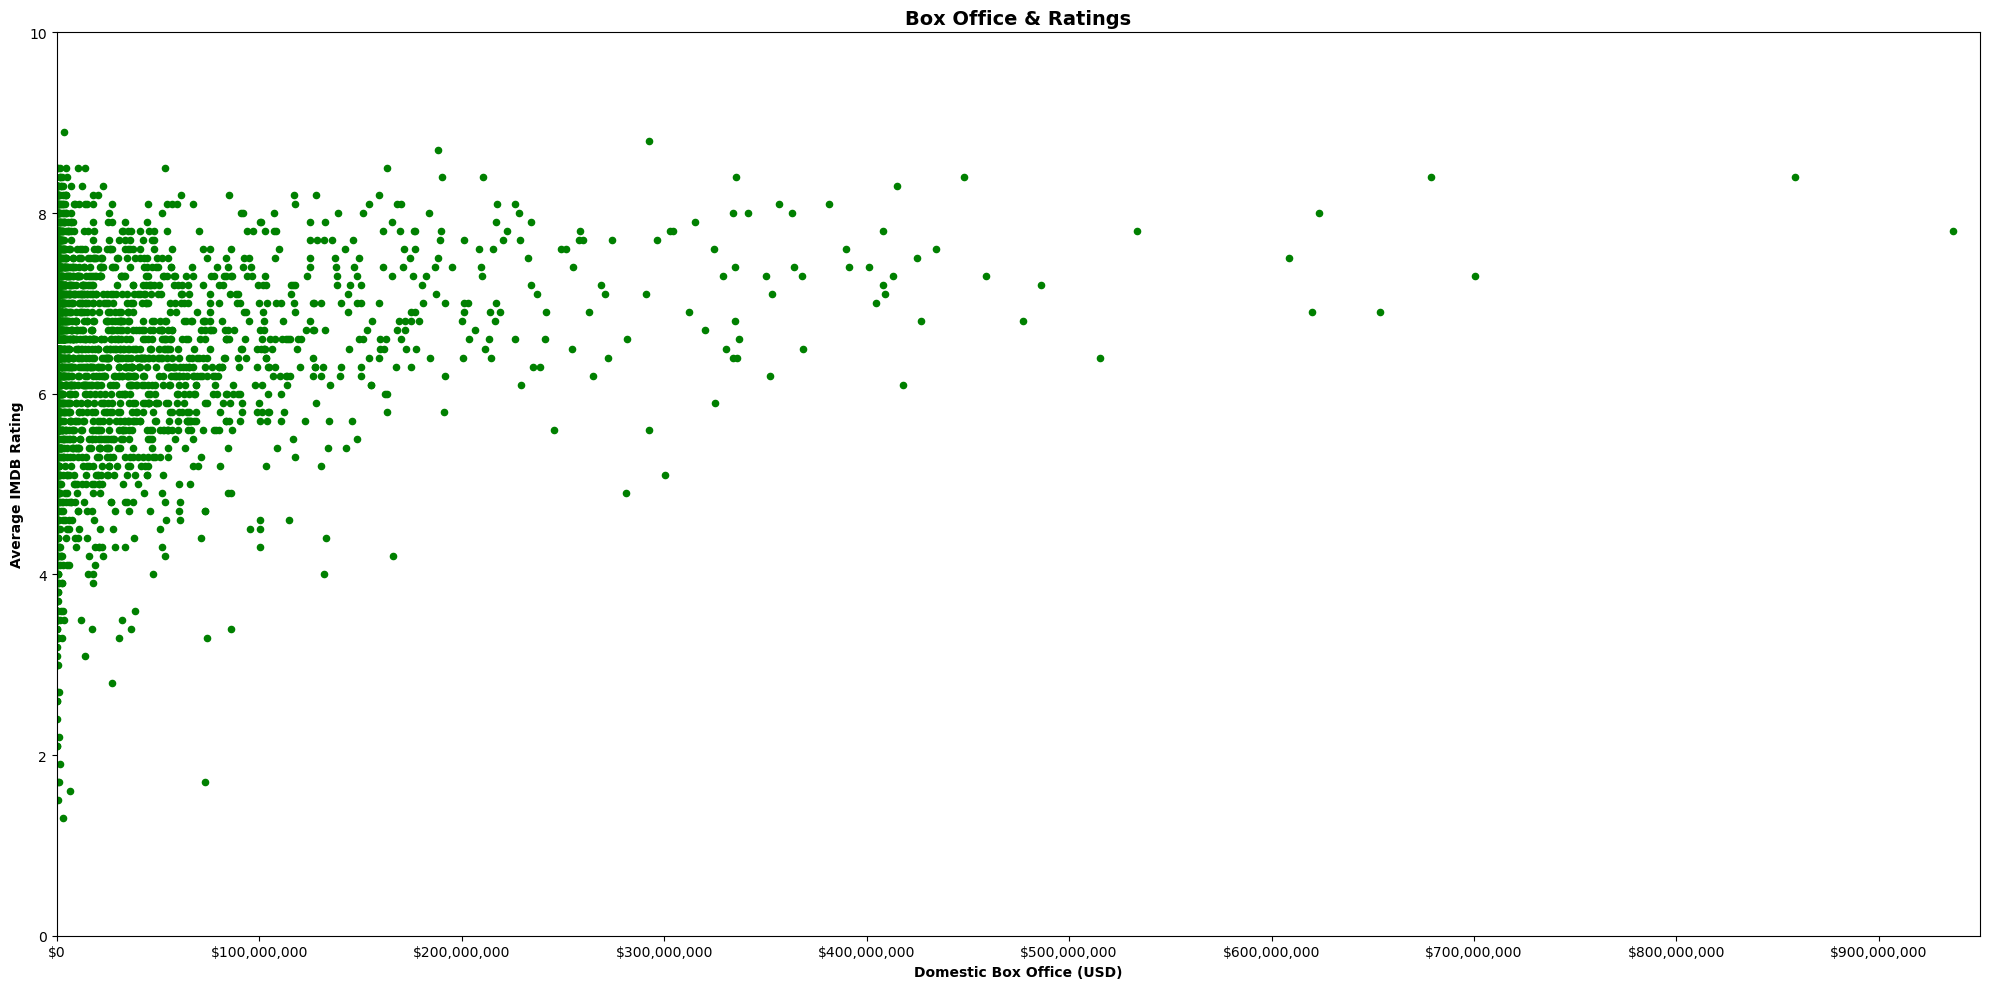

In [ ]:
# Create scatter plot
simplified.plot(x='BoxOffice',y='imdbRating', kind='scatter', figsize=(20,10), color='green', xlim=(10000,950000000))

# Customize plot
plt.ylim(0,10)
plt.xlim(10000, 950000000)
plt.xlabel('Domestic Box Office (USD)', fontdict={'size': 10, 'weight': 'bold'})
plt.ylabel('Average IMDB Rating', fontdict={'size': 10, 'weight': 'bold'})
plt.title('Box Office & Ratings', fontdict={'size': 14, 'weight': 'bold'})

# Fix the xticks
xticks = np.arange(0, 1000000000, 100000000)
xticklabels = []
for tick in xticks:
    xticklabels.append('${:,}'.format(tick))
plt.xticks(ticks=xticks, labels=xticklabels)


# Save plot to images folder
plt.tight_layout() # Fixes the png cutoff issue
plt.savefig('Images/box_office_scatter.png')

plt.show()

## Binning the data

In [11]:
# Get the range of box office values.
print(f'''
        Min. domestic box office: ${int(simplified['BoxOffice'].min())}
        Max. domestic box office: ${int(simplified['BoxOffice'].max())}
        ''')


        Min. domestic box office: $72
        Max. domestic box office: $936662225
        


A movie that made \\$72 at the box office is pretty irrelevant. We explored this movie's IMDB page and found out that this movie
was successful internationally, it just wasn't really released domestically. For now, let's get rid of values under $10k.

In [13]:
# Remove box office values <10k from dataframe
simplified = simplified.loc[(simplified['BoxOffice'] >= 10000), :]

In [14]:
# Identify 20 quantiles (attempted 10 - not much to look at)
quantiles = simplified['BoxOffice'].quantile([0,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1])
qlist = list(quantiles)

# Create bins
bins = []
for quantile in qlist:
    rounded = int(round(quantile, -3)) # Round to nearest thousand
    bins.append(rounded)
print(bins)

[10000, 17000, 29000, 47000, 73000, 112000, 165000, 253000, 383000, 614000, 1029000, 1703000, 3001000, 5706000, 12127000, 21357000, 34049000, 50278000, 75722000, 137527000, 936662000]


<!-- Let's simplify a few of these bins to make the numbers a bit more visually appealing. -->

In [16]:
# Simplify bins
bins = [10000, 15000, 30000, 45000, 75000, 115000, 175000, 250000, 375000, 600000, 1000000, 1700000, 
        3000000, 6000000, 12000000, 21000000, 34000000, 50000000, 75000000, 140000000, 950000000]

# Set up binning labels
labels = ['10k-15k', '15k-30k', '30k-45k', '45k-75k', '75k-115k', '115k-175k', '175k-250k', '250k-375k', '375k-600k', '600k-1M', 
          '1M-1.7M', '1.7M-3M', '3M-6M', '6M-12M', '12M-21M', '21M-34M',
          '34M-50M', '50M-75M', '75M-140M', '140M-950M']

# Bin the data
simplified['Bins'] = pd.cut(simplified['BoxOffice'], bins=bins, labels=labels)

simplified.head(20)

/var/folders/6v/g9_8y5jx4vg9cv9hp872jmdc0000gn/T/ipykernel_16964/2415344402.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simplified['Bins'] = pd.cut(simplified['BoxOffice'], bins=bins, labels=labels)


,BoxOffice,imdbRating,Title,Bins
0,25352281.0,7.9,Boyhood,21M-34M
1,27854932.0,7.4,Moonlight,21M-34M
3,47695371.0,7.8,Manchester by the Sea,34M-50M
4,274092705.0,7.7,Gravity,140M-950M
5,53369749.0,8.5,Parasite,50M-75M
6,56671993.0,8.1,12 Years a Slave,50M-75M
7,6739492.0,7.9,Amour,6M-12M
8,7099055.0,8.3,A Separation,6M-12M
10,96962694.0,7.8,The Social Network,75M-140M
11,3759854.0,8.1,Portrait of a Lady on Fire,3M-6M


## Plotting the data

/var/folders/6v/g9_8y5jx4vg9cv9hp872jmdc0000gn/T/ipykernel_16964/2012438978.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupedDF = simplified.groupby('Bins')


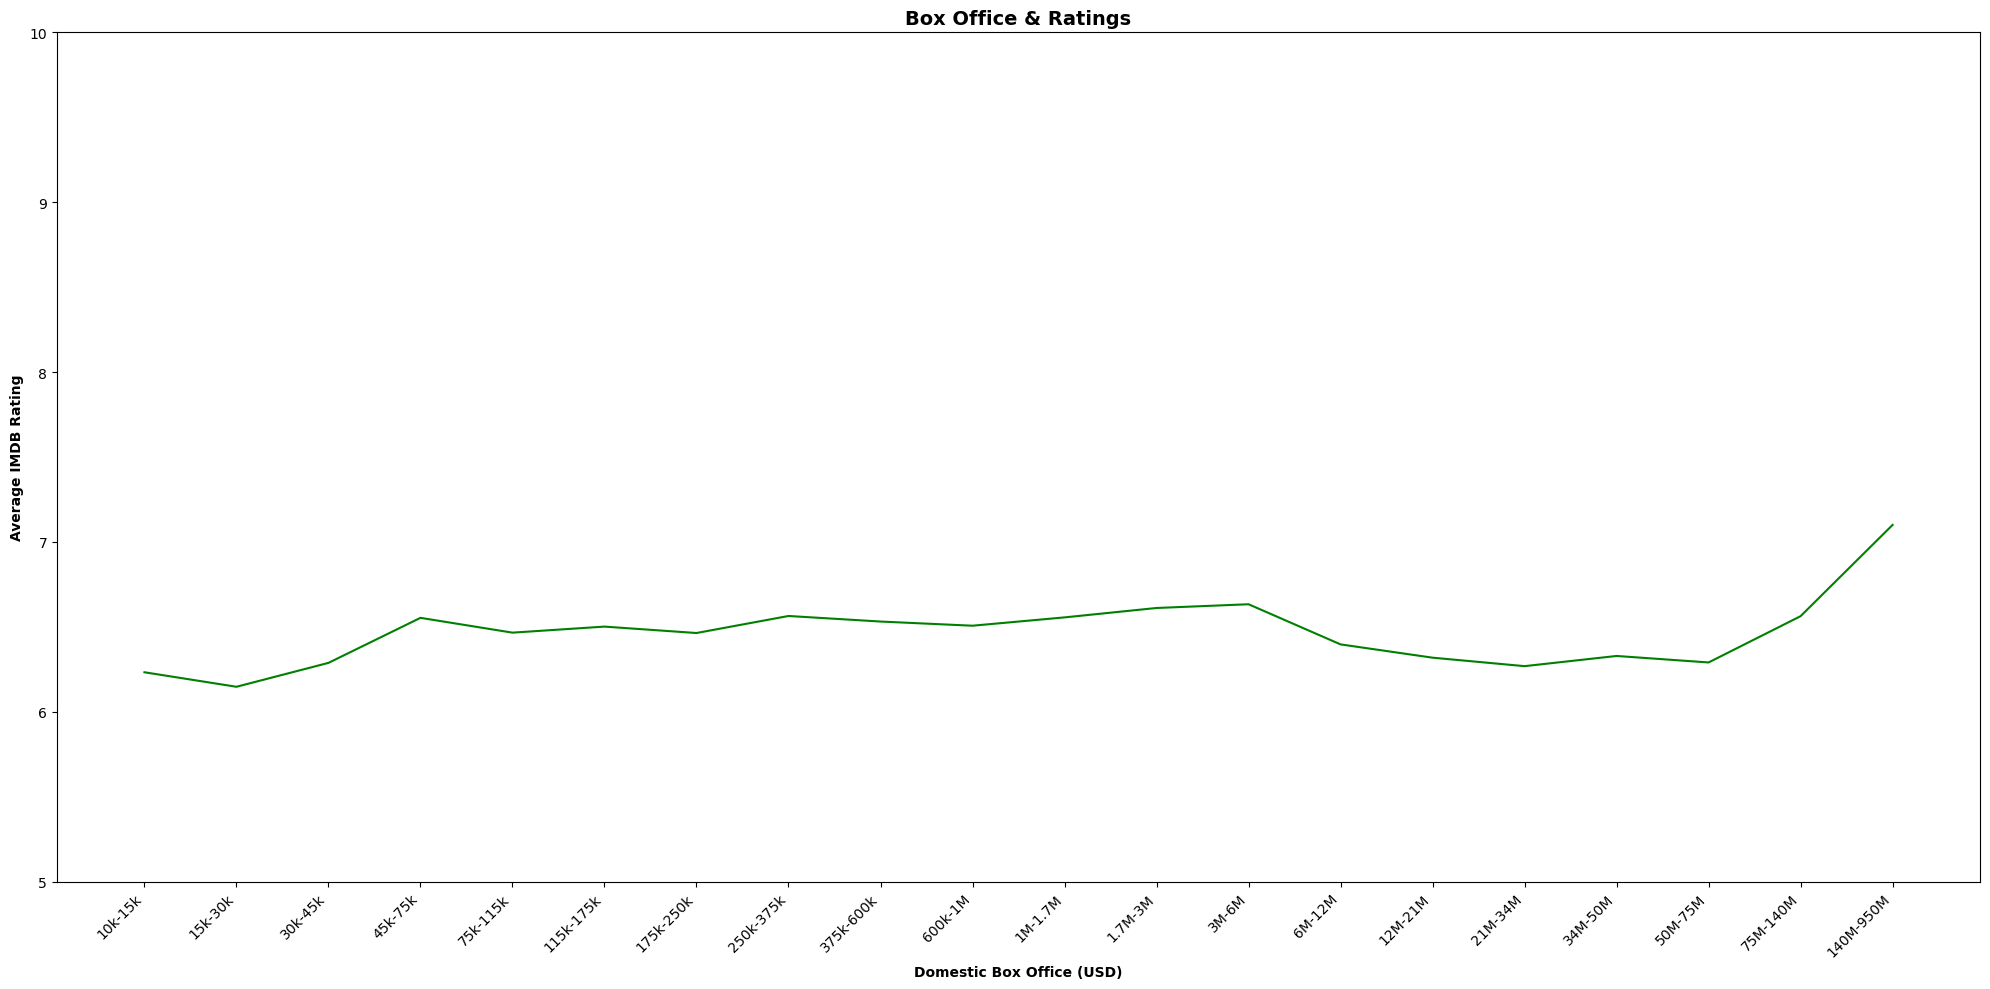

In [ ]:
# Group by the bins we just created
groupedDF = simplified.groupby('Bins')

# Plot box office vs. ratings
groupedDF['imdbRating'].mean().plot.line(figsize=(20,10), color='green')

# Customize plot
plt.ylim(5,10)
plt.xlabel('Domestic Box Office (USD)', fontdict={'size': 10, 'weight': 'bold'})
plt.ylabel('Average IMDB Rating', fontdict={'size': 10, 'weight': 'bold'})
plt.title('Box Office & Ratings', fontdict={'size': 14, 'weight': 'bold'})
plt.xticks(ticks=range(20), labels=labels, rotation=45, ha='right')

# Save plot to images folder
plt.tight_layout() # Fixes the png cutoff issue
plt.savefig('Images/box_office_binned.png')

plt.show()

In [19]:
# Loop through the bins to group the data & identify the ANOVA

groupList = []
for bin in labels:
    group = simplified[simplified['Bins'] == bin]['imdbRating']
    groupList.append(group)

f_statistic, p_value = f_oneway(*groupList) # asterisk just removes the brackets from the list so it doesn't throw an error

print("F-statistic:", f_statistic)
print("P-value:", p_value)

F-statistic: 9.757957499949912
P-value: 1.5154180638033762e-28


## Notes & conclusions
* Statistically significant (p-value of 1.5154180638033762e-28)! 
* As expected, movies that make the most at box office make for the highest IMDB ratings, and movies that tank at the box office average lower IMDB ratings
* You're better off seeing a movie that makes between \\$250k-\\$6M at the box office than you are going to a movie in the \\$6M-\\$50M range
* Could be interesting to compare the min/max ratings per bin
<!-- * (maxAvgRatings = groupedDF['imdbRating'].max() & minAvgRatings = groupedDF['imdbRating'].min()) -->